In [1]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter  # 导入SummaryWriter

import grid_env
from model import *
from render import *
import torch.nn as nn
import torch.nn.functional as F

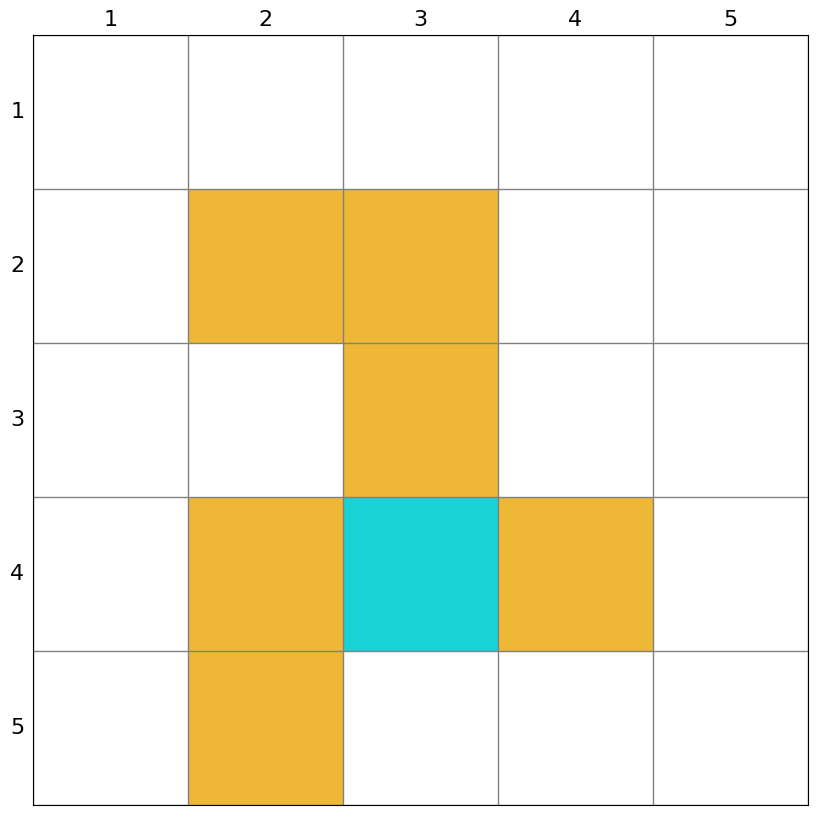

In [2]:
env = grid_env.GridEnv(size=5, target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], render_mode='')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Model(torch.nn.Module):
    def __init__(self, num_states = 25, embedding_dim = 32, hidden_layers = [64 , 128], action_dim = 5):
        super(Model, self).__init__()
        
        # Embedding layer to handle discrete states
        self.embedding = nn.Embedding(num_states, embedding_dim)  # Embedding layer
        
        # Sequential model for the hidden layers and output
        self.model = nn.Sequential()
        
        # First layer: from embedding_dim to the first hidden layer size
        self.model.add_module('layer0', nn.Linear(embedding_dim, hidden_layers[0]))
        
        # Hidden layers
        cnt = len(hidden_layers)
        for i in range(1, cnt):
            self.model.add_module(f'relu{i}', nn.ReLU())
            self.model.add_module(f'layer{i}', nn.Linear(hidden_layers[i-1], hidden_layers[i]))
        
        # Output layer
        self.model.add_module(f'relu{cnt}', nn.ReLU())
        self.model.add_module(f'layer{cnt}', nn.Linear(hidden_layers[cnt-1], action_dim))
            
    def forward(self, state):
        # If state is an integer, we convert it to a tensor
        if isinstance(state, int):
            state = torch.tensor([state], dtype=torch.long)
        
        # Pass the state through the embedding layer
        state_embedded = self.embedding(state)
        
        # Pass through the sequential model (hidden layers + output)
        output = F.softmax(self.model(state_embedded), dim=-1)
        return output
        
    def get_final_layer_parameters(self, state):
        if isinstance(state, int):
            state = torch.tensor([state], dtype=torch.long)
        
        # Pass the state through the embedding layer
        state_embedded = self.embedding(state)
        
        # Get the final layer output before softmax
        output = self.model(state_embedded)
        return output
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [4]:
import random
def obtain_episode(env, Qnet, start_state):
    action_space_size = env.action_space_size
    # 初始化环境到初始状态
    env.reset()
    env.agent_location = env.state2pos(start_state)
    next_state = start_state
    episode = []
    reward_sum = 0
    done = False

    while not done:
        state = next_state
        # 将 state 转换为 long tensor 传入 Q 网络
        state_tensor = torch.tensor([state], dtype=torch.long).to(device)

        # 前向传播获取动作价值
        value_combined = Qnet(state_tensor)

        # 使用 PyTorch 的 multinomial 直接在 GPU 上选择动作
        action_probabilities = value_combined.detach()
        action = torch.multinomial(action_probabilities, 1).item()  # 选取动作
        # 执行选择的动作
        _, reward, done, _, _ = env.step(action)
        reward_sum += reward
        over = 1 if done else 0
        # 获取下一个状态
        next_state = env.pos2state(env.agent_location)

        # 添加当前步骤的记录到 episode
        episode.append([state, action, reward, next_state, over])

    return episode, reward_sum


In [5]:
policy,_ = obtain_episode(env,model,0)
print(policy)

[[0, 2, 0, 5, 0], [5, 3, -0.1, 5, 0], [5, 3, -0.1, 5, 0], [5, 2, 0, 10, 0], [10, 2, 0, 15, 0], [15, 1, 0, 16, 0], [16, 0, -0.1, 11, 0], [11, 3, 0, 10, 0], [10, 1, -0.1, 11, 0], [11, 0, -0.1, 6, 0], [6, 2, -0.1, 11, 0], [11, 2, 0, 16, 0], [16, 0, -0.1, 11, 0], [11, 3, 0, 10, 0], [10, 3, -0.1, 10, 0], [10, 2, 0, 15, 0], [15, 4, 0, 15, 0], [15, 4, 0, 15, 0], [15, 0, 0, 10, 0], [10, 1, -0.1, 11, 0], [11, 3, 0, 10, 0], [10, 3, -0.1, 10, 0], [10, 0, 0, 5, 0], [5, 1, -0.1, 6, 0], [6, 1, 0, 7, 0], [7, 2, -0.1, 12, 0], [12, 3, -0.1, 11, 0], [11, 1, -0.1, 12, 0], [12, 0, 0, 7, 0], [7, 4, 0, 7, 0], [7, 4, 0, 7, 0], [7, 0, 0, 2, 0], [2, 2, 0, 7, 0], [7, 2, -0.1, 12, 0], [12, 0, 0, 7, 0], [7, 3, -0.1, 6, 0], [6, 1, 0, 7, 0], [7, 2, -0.1, 12, 0], [12, 0, 0, 7, 0], [7, 2, -0.1, 12, 0], [12, 1, 1, 13, 1]]


In [6]:
def compute_discounted_rewards(episode, gamma=0.99):
    rewards = [step[2] for step in episode]
    discounted_rewards = []
    cumulative_reward = 0
    for reward in reversed(rewards):
        cumulative_reward = reward + gamma * cumulative_reward
        discounted_rewards.insert(0, cumulative_reward)
    #为了防止发生梯度爆炸的情况，为每一个回报做标准化
    rewards_mean = np.mean(discounted_rewards)
    rewards_std = np.std(discounted_rewards) + 1e-9
    discounted_rewards = [(r - rewards_mean) / rewards_std for r in discounted_rewards]
    return discounted_rewards

In [ ]:
def reinforce_update(policy_net, episode, optimizer, gamma=0.99):
    # Step 1: 计算折扣奖励
    discounted_rewards = compute_discounted_rewards(episode, gamma)
    
    # 将episode的状态和动作分开处理，避免每次都调用torch.tensor()
    states = torch.tensor([step[0] for step in episode], dtype=torch.long).to(device)
    actions = torch.tensor([step[1] for step in episode], dtype=torch.long).to(device)
    
    # Step 2: 计算策略网络输出的log概率
    action_probs = policy_net(states)  # 批量计算
    log_probs = torch.log(action_probs[range(len(actions)), actions])
    
    # 将折扣奖励转换为张量
    rewards = torch.tensor(discounted_rewards).to(device)

    # Step 3: 计算损失函数（负的log概率乘以折扣奖励）
    loss = -(log_probs * rewards).sum()  # 使用批量操作减少循环，提高效率

    # Step 4: 梯度更新
    optimizer.zero_grad()  # 清除之前的梯度
    loss.backward()  # 反向传播计算梯度
    
    # 防止梯度爆炸：梯度裁剪
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=0.5)
    
    optimizer.step()  # 执行梯度下降更新

    return loss.item()


: 

In [ ]:
import random
# Training loop
num_episodes = 20000
gamma = 0.95  # Discount factor

for episode_num in range(num_episodes):
    env.reset()  # Get a new start state from the environment
    episode, reward_sum = obtain_episode(env, model, 0)
    loss = reinforce_update(model, episode, optimizer, gamma)

    if episode_num % 10 == 0:
        print(f"Episode {episode_num}: Loss = {loss} ; reward_sum = {reward_sum}")

Episode 0: Loss = -1.0958280718522992 ; reward_sum = -2.0000000000000013
Episode 10: Loss = 1.5843298375155275 ; reward_sum = -0.30000000000000004
Episode 20: Loss = -0.35368281417362946 ; reward_sum = 0.7
Episode 30: Loss = 1.8696763545678294 ; reward_sum = -0.5000000000000002
Episode 40: Loss = -0.2355444399899027 ; reward_sum = 0.9
Episode 50: Loss = -0.5013537654832287 ; reward_sum = -0.09999999999999987
Episode 60: Loss = -0.08864430443238414 ; reward_sum = 0.8
Episode 70: Loss = 0.8247202705518406 ; reward_sum = -0.09999999999999987
Episode 80: Loss = -0.023275340123448007 ; reward_sum = -0.5000000000000002
Episode 90: Loss = -0.24491761120067157 ; reward_sum = 0.7
Episode 100: Loss = -0.7681510999217775 ; reward_sum = 0.4
Episode 110: Loss = -0.26438791367316306 ; reward_sum = -0.09999999999999987
Episode 120: Loss = -0.6811044572047724 ; reward_sum = 0.7
Episode 130: Loss = -1.104527934483949 ; reward_sum = -1.9000000000000012
Episode 140: Loss = -0.14566619047870866 ; reward_s

In [1]:
# 通过模型获取一个episode
episode, treward = obtain_episode(env, model, 0 )
print(episode)

state_space_size = env.size ** 2
action_space_size = env.action_space_size
policy = np.ones((state_space_size, action_space_size))

for state in range(state_space_size):
    # 将状态转换为张量，并确保其形状与模型期望的输入一致
    state_tensor = torch.LongTensor([state]).to(device)
    
    # 模型预测的Q值，假设输出是所有动作的Q值
    q_values = model(state_tensor)
    
    # 获取当前状态下最优的动作
    best_action = q_values.argmax(dim=1).item()  # 获取最优动作索引
    
    # 直接在策略表中更新对应的最优动作的概率（这里可能是设置为1，或者某个概率分布）
    # 注意：policy存储的是每个状态-动作对的值，因此应更新对应位置
    for action in range(action_space_size):
        if action == best_action:
            policy[state][action] = 1.0  # 将最优动作的概率设为1
        else:
            policy[state][action] = 0.0  # 其他动作的概率设为0

# 输出最终的策略
print(policy)

NameError: name 'obtain_episode' is not defined

e:\Reinforcement_learning\scripts\render.py:153: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


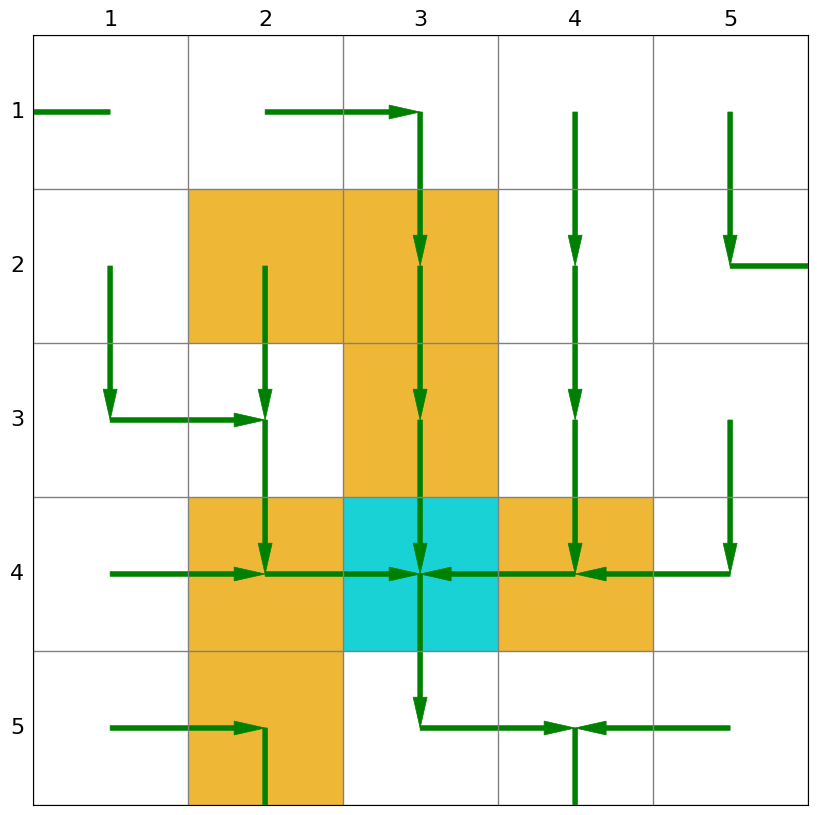

In [16]:
# 定义动作对应的方向
action_to_direction = {
    0: np.array([-1, 0]),
    1: np.array([0, 1]),
    2: np.array([1, 0]),
    3: np.array([0, -1]),
    4: np.array([0, 0]),
}
render = Render(target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], size=5)
# 绘制每个状态的最优动作
for state in range(policy.shape[0]):
    # 计算状态在网格中的位置
    row, col = env.state2pos(state)
    
    # 找出当前状态下的最优动作
    best_action = np.argmax(policy[state])
    
    # 根据最优动作绘制箭头
    render.draw_action(pos=[row, col], toward=action_to_direction[best_action])

# 显示结果
render.show_frame()